### Features Engineering

1) First step is to construct a ranking with a feature utility metric

2) Choose a smaller set of the most useful features to develop initially 

#### Mutual Information

Advantage of MI over correlation is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.

Technical note: "uncertainty" is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average."

If MI is zero, quantities are independent.

Things to remember:

    1) MI can help you to understand the relative potential of a feature as a predictor of the target.
    
    2) It's possible for a feature to be very informative when interacting with other features, but not so informative 
       all alone. MI can't detect interactions between features. It is a univariate metric.
       
    3) The actual usefulness of a feature depends on the model you use it with. Just because a feature has a high 
       MI score doesn't mean your model will be able to do anything with that information. You may need to transform 
       the feature.
       
    4) The scikit-learn algorithm for MI treats discrete features differently from continuous features. 
       Consequently, you need to tell it which are which. Scikit-learn has two mutual information metrics 
       in it feature_selection module:
            
            a) one for real-valued targets (mutual_info_regression) 

            b) one for categorical targets (mutual_info_classif).

In [ ]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

In [ ]:
def plot_utility_scores(scores):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_utility_scores(mi_scores)

In [ ]:
# As we might expect, the high-scoring curb_weight feature exhibits a strong relationship with price, the target.

sns.relplot(x="curb_weight", y="price", data=df);

# The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price 
# populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction. effect and might not be unimportant after all. 
# Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects 
# Domain knowledge can offer a lot of guidance here.

sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);


#### Features creation

In [ ]:
# Add a column with the number of elements greater than zero in each row

components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water", "Superplasticizer", "CoarseAggregate", "FineAggregate"]

concrete["Components"] = concrete[components].gt(0).sum(axis=1)

In [ ]:
# Split features

# Create two new features from the Policy feature through the string accessor by splitting on " " and expanding 
# the result into separate columns

customer[["Type", "Level"]] = (customer["Policy"].str.split(" ", expand=True))

customer[["Policy", "Type", "Level"]].head(10)

# Example
#       Policy         Type      Level
# 0	| Corporate L3 | Corporate | L3
# 1	| Personal L3  | Personal  | L3
# 2	| Personal L3  | Personel  | L3

In [ ]:
# Join simple features into a composed feature

autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

#       maker       body_style    make_and_style
# 0 | alfa-romero | convertible | alfa-romero_convertible
# 1 | alfa-romero | convertible | alfa-romero_convertible
# 2 | alfa-romero | hatchback   | alfa-romero_hatchback

In [ ]:
# Group transform

# For each state select the income and compute its mean

customer["AverageIncome"]=(customer.groupby("State")["Income"].transform("mean")) # mean, max, min, median, var, std, count

customer[["State", "Income", "AverageIncome"]].head(10)

# Frequency of each state
customer["StateFreq"] = (customer.groupby("State")["State"].transform("count") / customer.State.count())

customer[["State", "StateFreq"]].head(10)

In [ ]:
# If you're using training and validation splits, to preserve their independence, it's best to create a grouped  
# feature using only the training set and then join it to the validation set. 
# We can use the validation set's merge method after creating a unique set of values with drop_duplicates 
# on the training set:

# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(df_train[["Coverage", "AverageClaim"]].drop_duplicates(), on="Coverage", how="left")

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

    1) Linear models learn sums and differences naturally, but can't learn anything more complex.

    2) Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
    
    3) Linear models and neural nets generally do better with normalized features. Neural nets especially need 
       features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes 
       benefit from normalization, but usually much less so.

    4) Tree models can learn to approximate almost any combination of features, but when a combination is 
       especially important they can still benefit from having it explicitly created, especially when data is limited
       
    5) Counts are especially helpful for tree models, since these models don't have a natural way of 
       aggregating information across many features at once.

#### Interaction with categorical

In [16]:
import pandas as pd

df = pd.read_csv("Dataset/ames.csv")
X = df.copy()
y = X.pop("SalePrice")
#print(df.columns)

In [17]:
# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 =  pd.get_dummies(df.BldgType, prefix="Bldg")
df.BldgType.head()

0    OneFam
1    OneFam
2    OneFam
3    OneFam
4    OneFam
Name: BldgType, dtype: object

In [18]:
X_2.head()

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [19]:
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis=0)
X_2.head()

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0


### Clustering with K-Means

Clustering simply means the assigning of data points to groups based upon how similar the points are to each other.

When used for feature engineering, we could attempt discover groups that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle relationships of space or proximity.

Adding cluster labels breaks up complicated relationships across features into simpler chunks that have simpler relationships with dependent variables.


###### Algorithm
parameters: max_iter, n_init.

The algorithm starts by randomly initializing some predefined number (n_clusters) of centroids. It then iterates over these two operations:
    
    1) assign points to the nearest cluster centroid
    
    2) move each centroid to minimize the distance to its points

It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number of iterations has passed (max_iter).

Note that: 
- It often happens that the initial random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times (n_init) and returns the clustering that has the least total distance between each point and its centroid, the optimal clustering.

- Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with extreme values. 

- It's important to remember that this Cluster feature is categorical.


In [28]:
import pandas as pd

df = pd.read_csv("Dataset/housing.csv")
#y = df.pop("SalePrice")

X = df.loc[:, ["median_income", "latitude", "longitude"]]
#X = df[["median_income", "latitude", "longitude"]] -> !!! This doesn't work with K-means
df.head()
#X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [29]:
from sklearn.cluster import KMeans

# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,median_income,latitude,longitude,Cluster
0,8.3252,37.88,-122.23,5
1,8.3014,37.86,-122.22,5
2,7.2574,37.85,-122.24,5
3,5.6431,37.85,-122.25,5
4,3.8462,37.85,-122.25,2


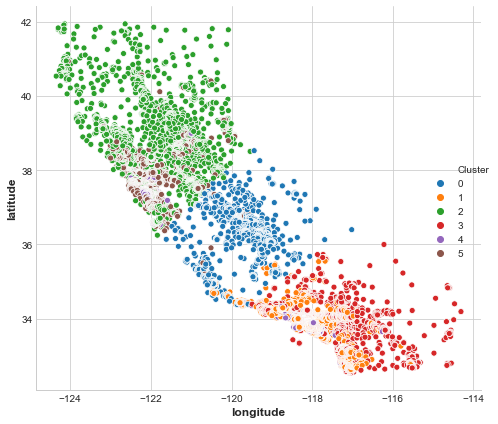

In [30]:
import seaborn as sns

sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=X, height=6,
);

The target in this dataset is MedHouseVal (median house value). These box-plots show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across MedHouseVal, which is indeed what we see.

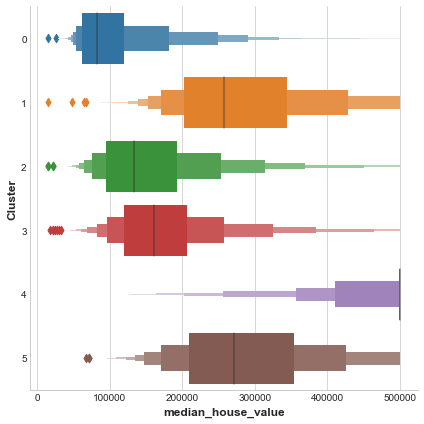

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

X["median_house_value"] = df["median_house_value"]
sns.catplot(x="median_house_value", y="Cluster", data=X, kind="boxen", height=6);

### Cluster-Distance Features

To get cluster-distance we can use fit_transform method of kmeans instead of fit_predict.

In [32]:
kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)


# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

### Principal Component Analysis

PCA is typically applied to standardized data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance".

PCA Best Practices:

- PCA only works with numeric features, like continuous quantities or counts.
- PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have 
  good reason not to.
- Consider removing or constraining outliers, since they can an have an undue influence on the results.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv("Dataset/Automobile_data.csv")

df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [ ]:
features = ['highway_mpg', 'engine_size', 'horsepower', 'curb_weight']

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [ ]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)

In [ ]:
X = X.join(X_pca)
score = score_dataset(X, y)

### Target Encoding

A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.
This kind of target encoding is sometimes called a mean encoding. Applied to a binary target, it's also called bin counting.

In [ ]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

In [16]:
#   make        price   make_encoded
# 0 alfa-romero 13495   15498.33
# 1 alfa-romero 16500   15498.33
# 2 alfa-romero 16500   15498.33
# 3 audi        13950   17859.16
# 4 audi        17450   17859.16
# 5 audi        15250   17859.16
# 6 audi        17710   17859.16
# 7 audi        18920   17859.16
# 8 audi        23875   17859.16
# 9 bmw         16430   26118.75

Overfitting problem of Target Encoding:

        1) Unknown categories. Pandas will fill in missing values for any categories not present in the encoding 
           split. These missing values you would have to impute somehow.
           
        2) Rare categories
        
#### Smoothing

A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average

In [ ]:
encoding = weight * in_category + (1 - weight) * overall

# weight is a value between 0 and 1 calculated from the category frequency.
# An easy way to determine the value for weight is to compute an m-estimate:

weight = n / (n + m)

# n is the total number of times that category occurs in the data. 
# The parameter m determines the "smoothing factor". Larger values of m put more weight on the overall estimate.

Use Cases for Target Encoding

1) High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.

2) Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

In [ ]:
# In order to find categorical data with a large number of categories
df.select_dtypes(["object"]).nunique()

# To see how many times a category occurs in the dataset
df["SaleType"].value_counts()

### M-Estimate Encoding

##### Important 
When using a target encoder it's very important to use separate data sets for training the encoder and training the model.

In [ ]:
from category_encoders import MEstimateEncoder

# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["SaleType","MSSubClass","Exterior1st","Exterior2nd"], m=5.0)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split to create the final training data
X_train = encoder.transform(X_pretrain, y_train)

### Permutation importance

If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(train_X, train_y)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Make a small change to the code below to use in this problem. 
perm = PermutationImportance(first_model, random_state=1).fit(val_X, val_y)

# Check your answer
q_2.check()

# uncomment the following line to visualize your results
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

### Partial Dependence Plots (PDP)

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

features_to_plot = ['Goal Scored', 'Distance Covered (Kms)'] # 2D partial plot

inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')

plt.show()